In [26]:
library(Seurat)
library(dplyr)
library(GSVA)
o<-function(w,h)options(repr.plot.width=w, repr.plot.height=h)

In [1]:
library(reticulate)
sc <- import("scanpy")
adata <- sc$read_h5ad("merged_alp_metacells.h5ad")
adata

AnnData object with n_obs × n_vars = 9405 × 31053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'doublet', 'pANN', 'pred.immgen.finepruned', 'pred.immgen.mainpruned', 'predicted.id', 'ann0608', 'S_score', 'G2M_score', 'phase', 'batch2', 'Phase', 'batch', 'ImmGen_refine', 'batch-ann0608', 'leiden', 'leiden_R', 'leiden_metacell', 'batch_leiden_metacell'
    uns: 'batch_leiden_metacell_colors', 'leiden_colors', 'leiden_metacell_colors'
    obsm: 'X_pca', 'X_umap'

In [8]:
exprs <- t(as.matrix(adata$X))
colnames(exprs) <- adata$obs_names$to_list()
rownames(exprs) <- adata$var_names$to_list()

# Create the Seurat object
seurat <- CreateSeuratObject(exprs)

# Set the expression assay
seurat <- SetAssayData(seurat, "data", exprs)

# Add observation metadata
seurat <- AddMetaData(seurat, adata$obs)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.2 GiB”
Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtdoubletpANNpred.immgen.fineprunedpred.immgen.mainprunedpredicted.idann0608S_scoreG2M_scorephasebatch2PhasebatchImmGen_refinebatch.ann0608leidenleiden_Rleiden_metacellbatch_leiden_metacell; see ?make.names for more details on syntax validity”


In [9]:
# Add embedding
embedding <- adata$obsm["X_umap"]
rownames(embedding) <- adata$obs_names$to_list()
colnames(embedding) <- c("umap_1", "umap_2")
seurat[["umap"]] <- CreateDimReducObject(embedding, key = "umap_")
ident=seu_metacell@meta.data$orig.ident
ident=gsub("ABMaLP1","ABM",ident)
ident=gsub("ABMaLP2","ABM",ident)
seu_metacell@meta.data$group<-ident

Warning message:
“No assay specified, setting assay as RNA by default.”


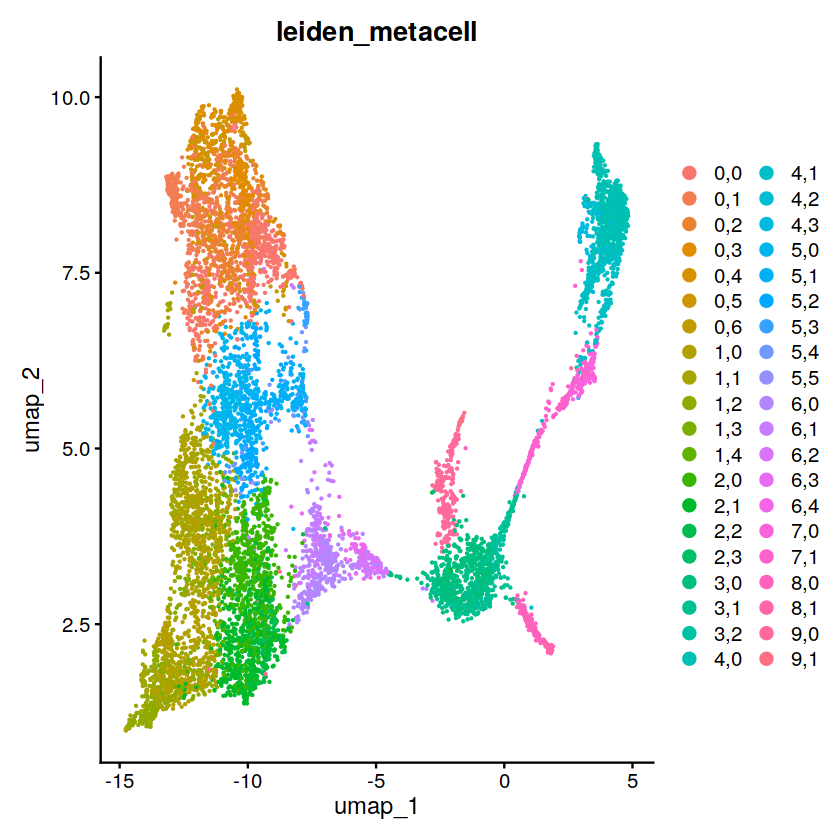

In [12]:
DimPlot(seurat, group.by='leiden_metacell')

In [14]:
seu_metacell = AverageExpression(seurat,
                                 return.seurat = T, 
                                 group.by='batch_leiden_metacell')

Centering and scaling data matrix



In [211]:
meta=seu_metacell@meta.data
cluster=sapply(strsplit(rownames(meta), "_"), function(x) x[[2]])
cluster=sapply(strsplit(cluster, ","), function(x) x[[1]])
seu_metacell@meta.data$cluster<-cluster

meta=seu_metacell@meta.data
meta$group_cluster <-paste(seu_metacell@meta.data$group, 
      seu_metacell@meta.data$cluster, sep='_' )
seu_metacell@meta.data<-meta

In [213]:
seu_metacell=FindVariableFeatures(seu_metacell)
seu_metacell = ScaleData(seu_metacell)

Centering and scaling data matrix



In [214]:
seu_metacell=RunPCA(seu_metacell, verbose = F)

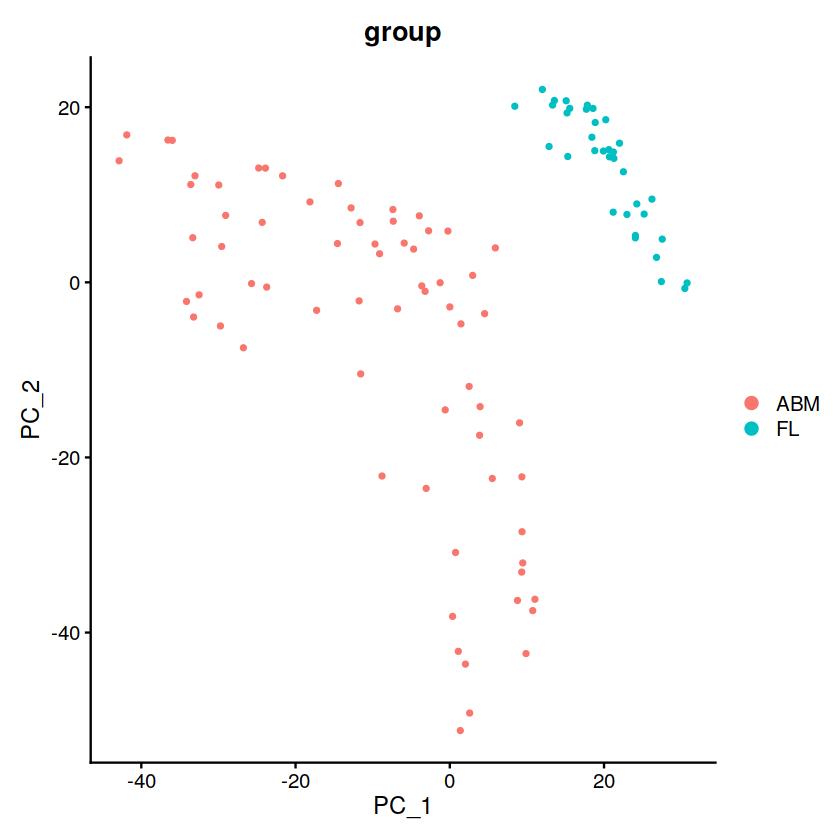

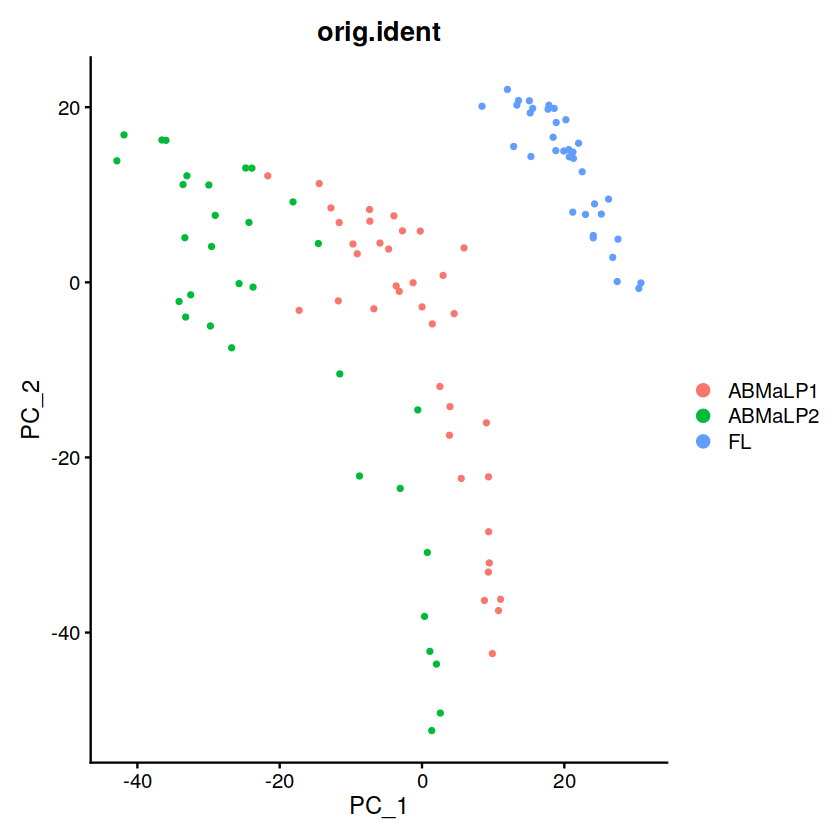

In [42]:
DimPlot(seu_metacell, group.by='group')
DimPlot(seu_metacell, group.by='orig.ident')

In [216]:
library(msigdbr)
library(dplyr)

m_gene_sets = msigdbr(species = "mouse", category = "H")
m_gene_sets = m_gene_sets %>% dplyr::select(gene_symbol,gs_name)%>%
        filter(gene_symbol %in%rownames(seu_metacell@assays$RNA@data))%>%
        group_by(gs_name) %>%
        summarise(genes = paste(gene_symbol, collapse=", "))

terms<-gsub("HALLMARK_","", m_gene_sets$gs_name)
terms<-gsub("_"," ", terms)

library(stringr)
library(purrr)
str_to_title(terms) %>%
map(~ gsub("Dna", "DNA", .)) %>% unlist %>%
map(~ gsub("G2m", "G2M", .)) %>% unlist %>%
map(~ gsub("E2f", "E2F", .)) %>% unlist %>%
map(~ gsub("Kras", "KRAS", .)) %>% unlist %>%
map(~ gsub("Il2", "IL2", .)) %>% unlist %>%
map(~ gsub("Il6", "IL6", .)) %>% unlist %>%
map(~ gsub("Stat5", "STAT5", .)) %>% unlist %>%
map(~ gsub("Tgf", "TGF", .)) %>% unlist %>%
map(~ gsub("Tnfa", "TNFa", .)) %>% unlist %>%
map(~ gsub("Pi3k", "PI3K", .)) %>% unlist %>%
map(~ gsub("Nfkb", "NFkB", .)) %>% unlist %>%
map(~ gsub("Mtorc1", "mTORC1", .)) %>% unlist %>%
map(~ gsub("Beta", "beta", .)) %>% unlist %>%
map(~ gsub("Alpha", "alpha", .)) %>% unlist %>%
map(~ gsub("Gamma", "gamma", .)) %>% unlist %>%
map(~ gsub("PI3K Akt Mtor", "PI3K AKT mTOR", .)) %>% unlist %>%
map(~ gsub("Uv", "UV", .)) %>% unlist ->terms

m_gene_sets$gs_name <-terms

term2genes <- strsplit(m_gene_sets$genes, ', ')
names(term2genes) <- m_gene_sets$gs_name

In [217]:
expr <- seu_metacell@assays$RNA@data
gsva.result = gsva(as.matrix(expr), gset.idx.list = term2genes)
gsva.result=t(scale(t(gsva.result)))

Estimating GSVA scores for 50 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



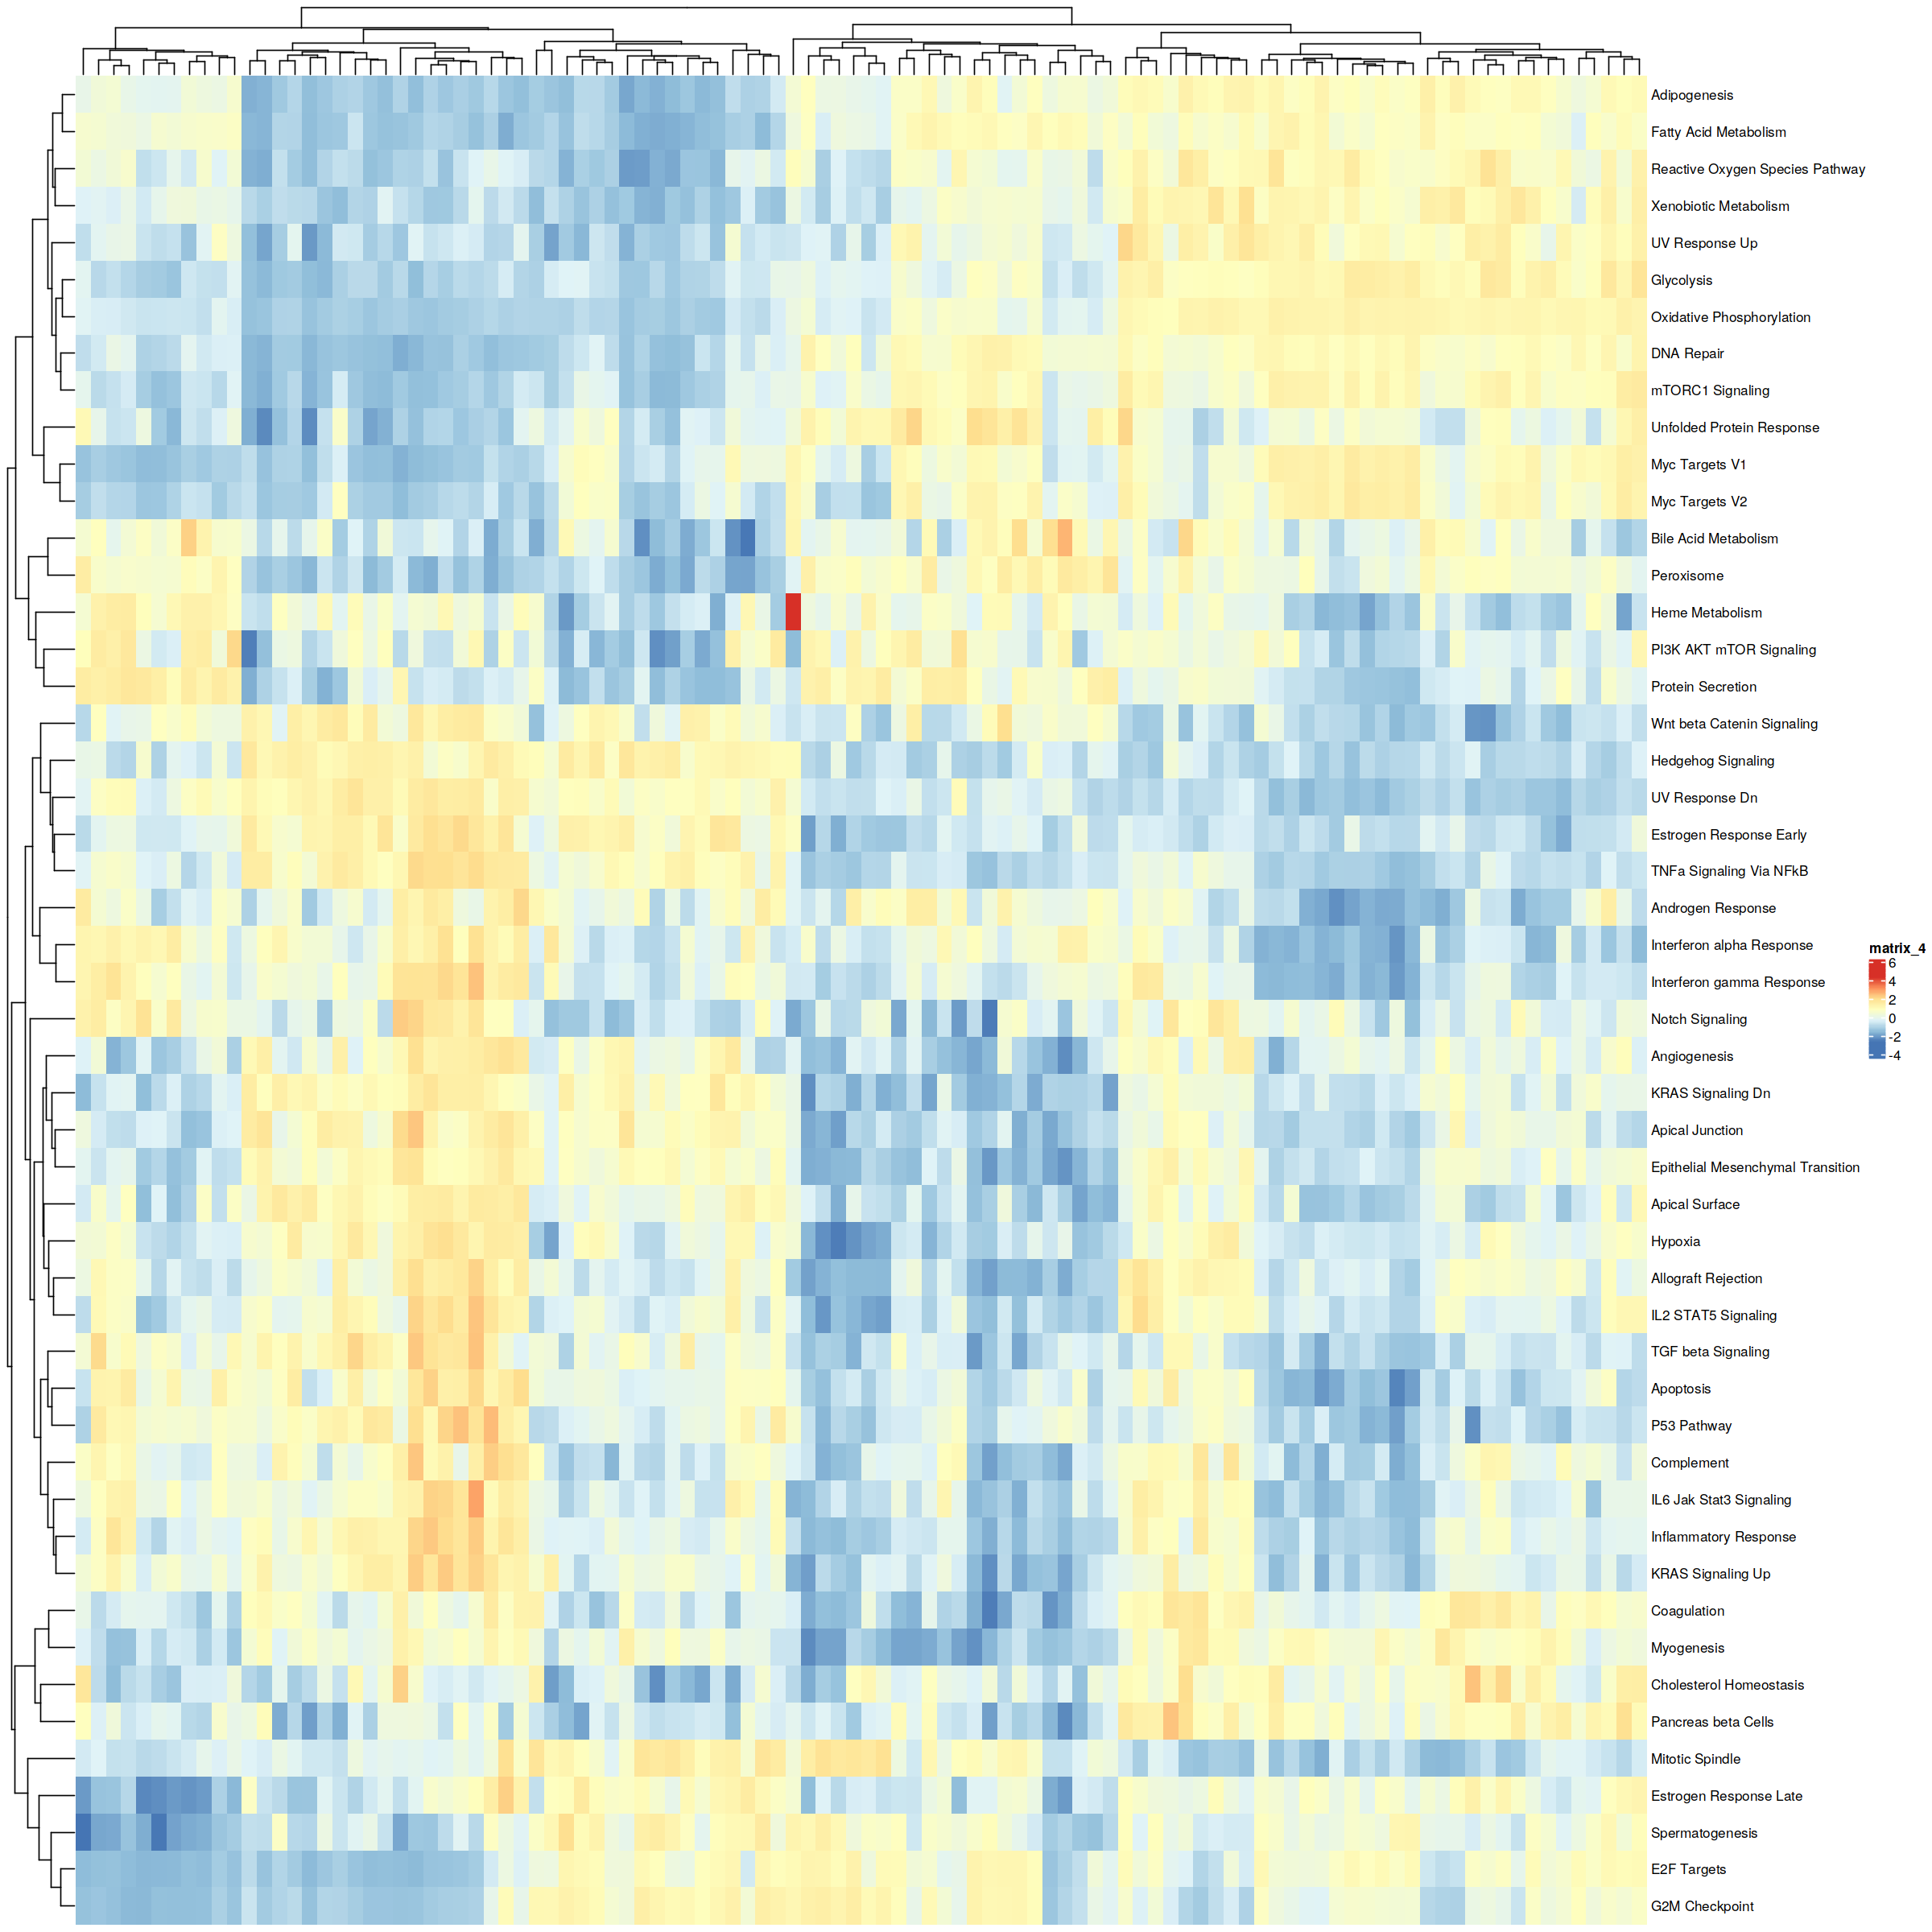

In [228]:
library(pheatmap)
pheatmap(gsva.result, show_rownames = T, show_colnames = F)

In [232]:
library(ComplexHeatmap)
library(circlize)
meta= seu_metacell@meta.data
mat = gsva.result

In [236]:
meta

,orig.ident,nCount_RNA,nFeature_RNA,group,cluster,group_cluster
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>
"ABMaLP1_0,0",ABMaLP1,10117.13,12108,ABM,0,ABM_0
"ABMaLP1_0,1",ABMaLP1,10134.50,11509,ABM,0,ABM_0
"ABMaLP1_0,2",ABMaLP1,10153.93,11704,ABM,0,ABM_0
"ABMaLP1_0,3",ABMaLP1,10171.86,10321,ABM,0,ABM_0
"ABMaLP1_0,4",ABMaLP1,10177.99,9476,ABM,0,ABM_0
"ABMaLP1_0,5",ABMaLP1,10124.54,10027,ABM,0,ABM_0
"ABMaLP1_0,6",ABMaLP1,10297.58,10518,ABM,0,ABM_0
"ABMaLP1_1,0",ABMaLP1,10134.06,12415,ABM,1,ABM_1
"ABMaLP1_1,1",ABMaLP1,10304.69,10878,ABM,1,ABM_1


In [246]:
meta

,orig.ident,nCount_RNA,nFeature_RNA,group,cluster,group_cluster
,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>
"ABMaLP1_0,0",ABMaLP1,10117.13,12108,ABM,0,ABM_0
"ABMaLP1_0,1",ABMaLP1,10134.50,11509,ABM,0,ABM_0
"ABMaLP1_0,2",ABMaLP1,10153.93,11704,ABM,0,ABM_0
"ABMaLP1_0,3",ABMaLP1,10171.86,10321,ABM,0,ABM_0
"ABMaLP1_0,4",ABMaLP1,10177.99,9476,ABM,0,ABM_0
"ABMaLP1_0,5",ABMaLP1,10124.54,10027,ABM,0,ABM_0
"ABMaLP1_0,6",ABMaLP1,10297.58,10518,ABM,0,ABM_0
"ABMaLP1_1,0",ABMaLP1,10134.06,12415,ABM,1,ABM_1
"ABMaLP1_1,1",ABMaLP1,10304.69,10878,ABM,1,ABM_1


In [263]:
colann <- HeatmapAnnotation(
    group   = meta$group,
    cluster = meta$cluster,
    group_cluster = meta$group_cluster,
    col = list(
        #ident = c('FL'='red','ABMaLP1'="green",'ABMaLP2'="blue"), 
        group=c('FL'='red' ,'ABM'="green") 
    ),
    annotation_legend_param=list(
        #ident = list(nrow=1),
        group=list(nrow=1),
        cluster = list(nrow=1),group_cluster=list(nrow=3)
    )
)

In [264]:
hm<-Heatmap(mat, name = "GSVA scores", 
        cluster_rows = T, column_split=meta$group_cluster,
        cluster_columns = T, cluster_column_slices=T, show_column_names=FALSE,
        column_dend_height = unit(4, "cm"),
        row_km=4,
        #column_split=meta$organ, cluster_column_slices=T,
        col= colorRamp2(c(-2,0,2), c("#486E9E", "white", "#D84B59")),
        column_title_rot=90, column_gap=unit(2, "mm"),
        top_annotation=colann, heatmap_legend_param = list(direction = "horizontal"),
        use_raster = TRUE)

options(warn=-1)
options(repr.plot.width=20, repr.plot.height=20)
cairo_pdf("GSVA-metabo.hm.pdf",width=20, height = 14)
draw(hm,
     padding = unit(c(10, 10, 30, 3), "mm"), #下左上右
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")
dev.off()

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2